# Migration Planning Analysis Notebook

This notebook runs the full migration planning pipeline step-by-step, captures timings, computes clustering metrics, and generates interactive visualizations for analysis. It expects the project layout under `d:/Projects/Graph_Clustering/migration_planning/` and will save outputs under `outputs/`.

Sections:
1. Install dependencies (optional)
2. Imports and reproducibility
3. Load / generate dataset
4. Basic graph stats
5. Louvain clustering
6. Leiden clustering
7. Additional clustering baselines
8. Clustering metrics (modularity, NMI, ARI, silhouette)
9. Visualizations (matplotlib + plotly)
10. Parameter sweep and stability
11. Comparison tables & Sankey
12. Save and export
13. Basic validations and checks

Run cells one-by-one to reproduce the analysis.

In [18]:
# Section 1: Install dependencies (one-by-one, timed)
import subprocess, sys, time
from pathlib import Path
req_file = Path('d:/Projects/Graph_Clustering/migration_planning/requirements.txt')
pkgs = []
if req_file.exists():
    with open(req_file,'r') as f:
        for ln in f:
            ln = ln.strip()
            if ln and not ln.startswith('#'):
                pkgs.append(ln)
else:
    pkgs = ['pandas','numpy','networkx','python-louvain','python-igraph','leidenalg','matplotlib','seaborn','graphviz','plotly','scikit-learn','tqdm','pyyaml']

results = []
for pkg in pkgs:
    print(f"Installing {pkg}...")
    start = time.perf_counter()
    proc = subprocess.run([sys.executable, '-m', 'pip', 'install', pkg], capture_output=True, text=True)
    dur = time.perf_counter() - start
    ok = proc.returncode == 0
    print(f"{pkg}: {'OK' if ok else 'FAILED'} in {dur:.1f}s")
    if not ok:
        print(proc.stdout[:200])
        print(proc.stderr[:200])
    results.append({'package':pkg,'returncode':proc.returncode,'time_s':dur})

import pandas as pd
pd.DataFrame(results)


Installing pandas...
pandas: OK in 3.3s
Installing numpy...
numpy: OK in 3.2s
Installing networkx...
networkx: OK in 3.2s
Installing python-louvain...
python-louvain: OK in 3.2s
Installing python-igraph...
python-igraph: OK in 3.8s
Installing leidenalg...
leidenalg: OK in 4.6s
Installing matplotlib...
matplotlib: OK in 4.2s
Installing seaborn...
seaborn: OK in 4.2s
Installing graphviz...
graphviz: OK in 4.0s
Installing plotly...
plotly: OK in 4.0s
Installing scikit-learn...
scikit-learn: OK in 4.0s
Installing tqdm...
tqdm: OK in 4.2s
Installing pyyaml...
pyyaml: OK in 4.0s


package  returncode    time_s
0           pandas           0  3.346826
1            numpy           0  3.180283
2         networkx           0  3.227984
3   python-louvain           0  3.151518
4    python-igraph           0  3.800502
5        leidenalg           0  4.640770
6       matplotlib           0  4.179388
7          seaborn           0  4.165652
8         graphviz           0  4.048214
9           plotly           0  3.996559
10    scikit-learn           0  4.000125
11            tqdm           0  4.235083
12          pyyaml           0  3.998691

In [19]:
# Section 2: Imports and reproducibility
import os, random, time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display, HTML

# Optional third-party
try:
    import community as community_louvain
except Exception as e:
    community_louvain = None
try:
    import igraph as ig
    import leidenalg
except Exception as e:
    ig = None
    leidenalg = None

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import SpectralClustering

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

plt.rcParams.update({'figure.figsize':(8,6),'figure.dpi':120})
import plotly.io as pio
pio.renderers.default = 'notebook'


In [20]:
# Section 3: Load or generate graph dataset
DATA_DIR = Path('d:/Projects/Graph_Clustering/migration_planning/data')
OUT_DIR = Path('d:/Projects/Graph_Clustering/migration_planning/outputs')

if (DATA_DIR / 'apps.csv').exists() and (DATA_DIR / 'dependencies.csv').exists():
    apps = pd.read_csv(DATA_DIR / 'apps.csv')
    deps = pd.read_csv(DATA_DIR / 'dependencies.csv')
    servers = pd.read_csv(DATA_DIR / 'servers.csv') if (DATA_DIR / 'servers.csv').exists() else pd.DataFrame()
    dbs = pd.read_csv(DATA_DIR / 'databases.csv') if (DATA_DIR / 'databases.csv').exists() else pd.DataFrame()
    print('Loaded dataset: applications:', len(apps), 'dependencies:', len(deps))
    # Build undirected app->app graph (weight summed)
    app_nodes = apps['app_instance_id'].tolist()
    G = nx.Graph()
    G.add_nodes_from(app_nodes)
    for _, r in deps.iterrows():
        if r['source_type']=='application' and r['target_type']=='application':
            u,v = r['source'], r['target']
            if G.has_edge(u,v):
                G[u][v]['weight'] += float(r['weight'])
            else:
                G.add_edge(u,v,weight=float(r['weight']))
else:
    print('Application dataset not found; falling back to Karate Club')
    G = nx.karate_club_graph()
    # add weight 1
    for u,v in G.edges():
        G[u][v]['weight'] = 1.0

print('Graph nodes:', G.number_of_nodes(), 'edges:', G.number_of_edges())


Loaded dataset: applications: 600 dependencies: 3684
Graph nodes: 600 edges: 1267


|V|=600, |E|=1267, density=0.0071, avg_clustering=0.0100, #components=23


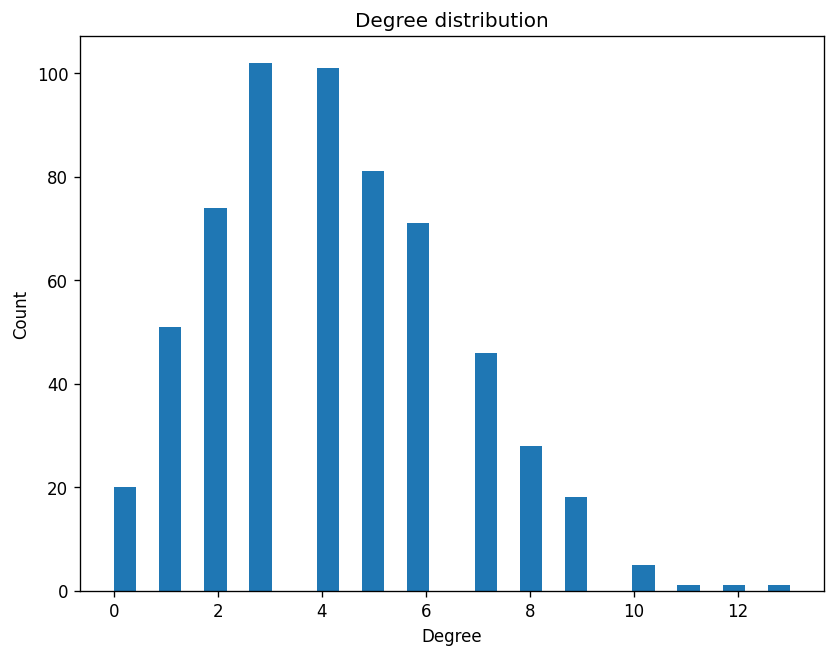

metric        value
0           nodes   600.000000
1           edges  1267.000000
2         density     0.007051
3  avg_clustering     0.010012
4      components    23.000000

In [21]:
# Section 4: Basic graph statistics and plots
import numpy as np

n = G.number_of_nodes(); m = G.number_of_edges()
deg_seq = [d for n,d in G.degree()]
density = nx.density(G)
cc = nx.average_clustering(G)
components = list(nx.connected_components(G))
largest_cc = max(components, key=len)

print(f"|V|={n}, |E|={m}, density={density:.4f}, avg_clustering={cc:.4f}, #components={len(components)}")

# Degree histogram
plt.figure()
plt.hist(deg_seq, bins=30)
plt.title('Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

# Show table summary
import pandas as pd
pd.DataFrame({'metric':['nodes','edges','density','avg_clustering','components'],'value':[n,m,density,cc,len(components)]})


Louvain: 40 communities, runtime 0.06s
Louvain modularity: 0.5069108065124784


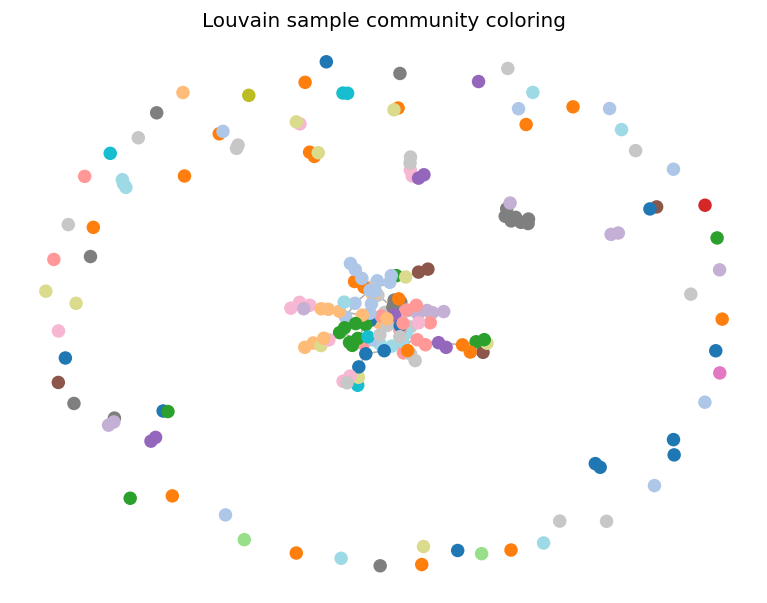

Saved d:\Projects\Graph_Clustering\migration_planning\outputs\partitions_louvain.json


In [22]:
# Section 5: Run Louvain clustering (single run)
import time
if community_louvain is None:
    print('python-louvain not available. Please install python-louvain to run Louvain.')
else:
    start = time.perf_counter()
    partition = community_louvain.best_partition(G, weight='weight')
    duration = time.perf_counter() - start
    # community sizes
    from collections import Counter
    sizes = Counter(partition.values())
    print(f'Louvain: {len(sizes)} communities, runtime {duration:.2f}s')
    # attach community to node attributes
    nx.set_node_attributes(G, partition, 'louvain')
    # modularity
    modularity = community_louvain.modularity(partition, G, weight='weight')
    print('Louvain modularity:', modularity)
    # sample visualization (small graph)
    import matplotlib.pyplot as plt
    sample_nodes = list(G.nodes())[:200]
    H = G.subgraph(sample_nodes)
    pos = nx.spring_layout(H, seed=SEED)
    cmap = plt.get_cmap('tab20')
    colors = [cmap(partition.get(n,0) % 20) for n in H.nodes()]
    plt.figure(figsize=(8,6))
    nx.draw_networkx_nodes(H, pos, node_color=colors, node_size=50)
    nx.draw_networkx_edges(H, pos, alpha=0.3)
    plt.title('Louvain sample community coloring')
    plt.axis('off')
    plt.show()
    # save partition
    import json
    outp = Path('d:/Projects/Graph_Clustering/migration_planning/outputs/partitions_louvain.json')
    with open(outp,'w') as f:
        json.dump({n:int(c) for n,c in partition.items()}, f)
    print('Saved', outp)


In [23]:
# Section 6: Run Leiden clustering (single run)
if ig is None or leidenalg is None:
    print('igraph/leidenalg not available. Please install python-igraph and leidenalg to run Leiden.')
else:
    # build igraph
    mapping = {n:i for i,n in enumerate(G.nodes())}
    edges = [(mapping[u], mapping[v]) for u,v in G.edges()]
    weights = [G[u][v].get('weight',1.0) for u,v in G.edges()]
    g_ig = ig.Graph()
    g_ig.add_vertices(len(mapping))
    if edges:
        g_ig.add_edges(edges)
        g_ig.es['weight'] = weights
    start = time.perf_counter()
    part = leidenalg.find_partition(g_ig, leidenalg.ModularityVertexPartition, weights='weight', seed=SEED)
    duration = time.perf_counter() - start
    membership = part.membership
    # map back to node ids
    partition_leiden = {list(mapping.keys())[i]: int(membership[i]) for i in range(len(membership))}
    print(f'Leiden: {len(set(membership))} communities, runtime {duration:.2f}s')
    # compute modularity
    mod_leiden = g_ig.modularity(membership, weights=weights) if g_ig.vcount()>0 else None
    print('Leiden modularity:', mod_leiden)
    nx.set_node_attributes(G, partition_leiden, 'leiden')
    # save
    import json
    outp = Path('d:/Projects/Graph_Clustering/migration_planning/outputs/partitions_leiden.json')
    with open(outp,'w') as f:
        json.dump(partition_leiden, f)
    print('Saved', outp)


Leiden: 37 communities, runtime 0.00s
Leiden modularity: 0.518331017249938
Saved d:\Projects\Graph_Clustering\migration_planning\outputs\partitions_leiden.json


In [24]:
# Section 7: Additional clustering baselines
# 7.1: igraph Infomap (if available)
partitions = {}
if ig is not None:
    try:
        start = time.perf_counter()
        infomap = g_ig.community_infomap(edge_weights='weight')
        dur = time.perf_counter() - start
        mem = infomap.membership
        part_infomap = {list(mapping.keys())[i]: int(mem[i]) for i in range(len(mem))}
        partitions['infomap'] = part_infomap
        print('Infomap communities:', len(set(mem)), 'runtime', dur)
    except Exception as e:
        print('Infomap failed:', e)

# 7.2: Spectral clustering on adjacency
try:
    from sklearn.cluster import SpectralClustering
    A = nx.to_numpy_array(G)
    n_clusters = max(2, int(np.sqrt(G.number_of_nodes())))
    start = time.perf_counter()
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=SEED)
    labels = sc.fit_predict(A)
    dur = time.perf_counter() - start
    part_spec = {list(G.nodes())[i]: int(labels[i]) for i in range(len(labels))}
    partitions['spectral'] = part_spec
    print('Spectral clustering', n_clusters, 'clusters, runtime', dur)
except Exception as e:
    print('Spectral clustering failed:', e)


Infomap communities: 93 runtime 0.07064480000008189
Spectral clustering 24 clusters, runtime 0.15484709999873303


c:\Users\31649\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [25]:
# Section 8: Compute clustering metrics (modularity, NMI, ARI, silhouette)
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

results = []
# collect partitions: louvain, leiden, plus others
all_parts = {}
if 'louvain' in nx.get_node_attributes(G,'louvain'):
    all_parts['louvain'] = nx.get_node_attributes(G,'louvain')
if 'leiden' in nx.get_node_attributes(G,'leiden'):
    all_parts['leiden'] = nx.get_node_attributes(G,'leiden')
all_parts.update(partitions)

# convert node-ordered label arrays
nodes = list(G.nodes())
label_arrays = {k: [v.get(n, -1) if isinstance(v, dict) else v[n] for n in nodes] for k,v in all_parts.items()}

# modularity
for name, labels in label_arrays.items():
    try:
        if name == 'louvain':
            mod = community_louvain.modularity({n: label_arrays['louvain'][i] for i,n in enumerate(nodes)}, G, weight='weight')
        elif name == 'leiden':
            mem = [labels[i] for i in range(len(nodes))]
            mod = g_ig.modularity(mem, weights=weights)
        else:
            # fallback: compute with igraph if possible
            mod = None
        results.append({'algorithm':name,'modularity':mod,'num_communities':len(set(labels))})
    except Exception as e:
        results.append({'algorithm':name,'modularity':None,'num_communities':len(set(labels))})

# pairwise NMI/ARI
pairs = []
names = list(label_arrays.keys())
for i in range(len(names)):
    for j in range(i+1, len(names)):
        a = names[i]; b = names[j]
        nmi = normalized_mutual_info_score(label_arrays[a], label_arrays[b])
        ari = adjusted_rand_score(label_arrays[a], label_arrays[b])
        pairs.append({'algA':a,'algB':b,'NMI':nmi,'ARI':ari})

pd.DataFrame(results), pd.DataFrame(pairs)


(  algorithm modularity  num_communities
 0   infomap       None               93
 1  spectral       None               24,
       algA      algB       NMI       ARI
 0  infomap  spectral  0.452087  0.034454)

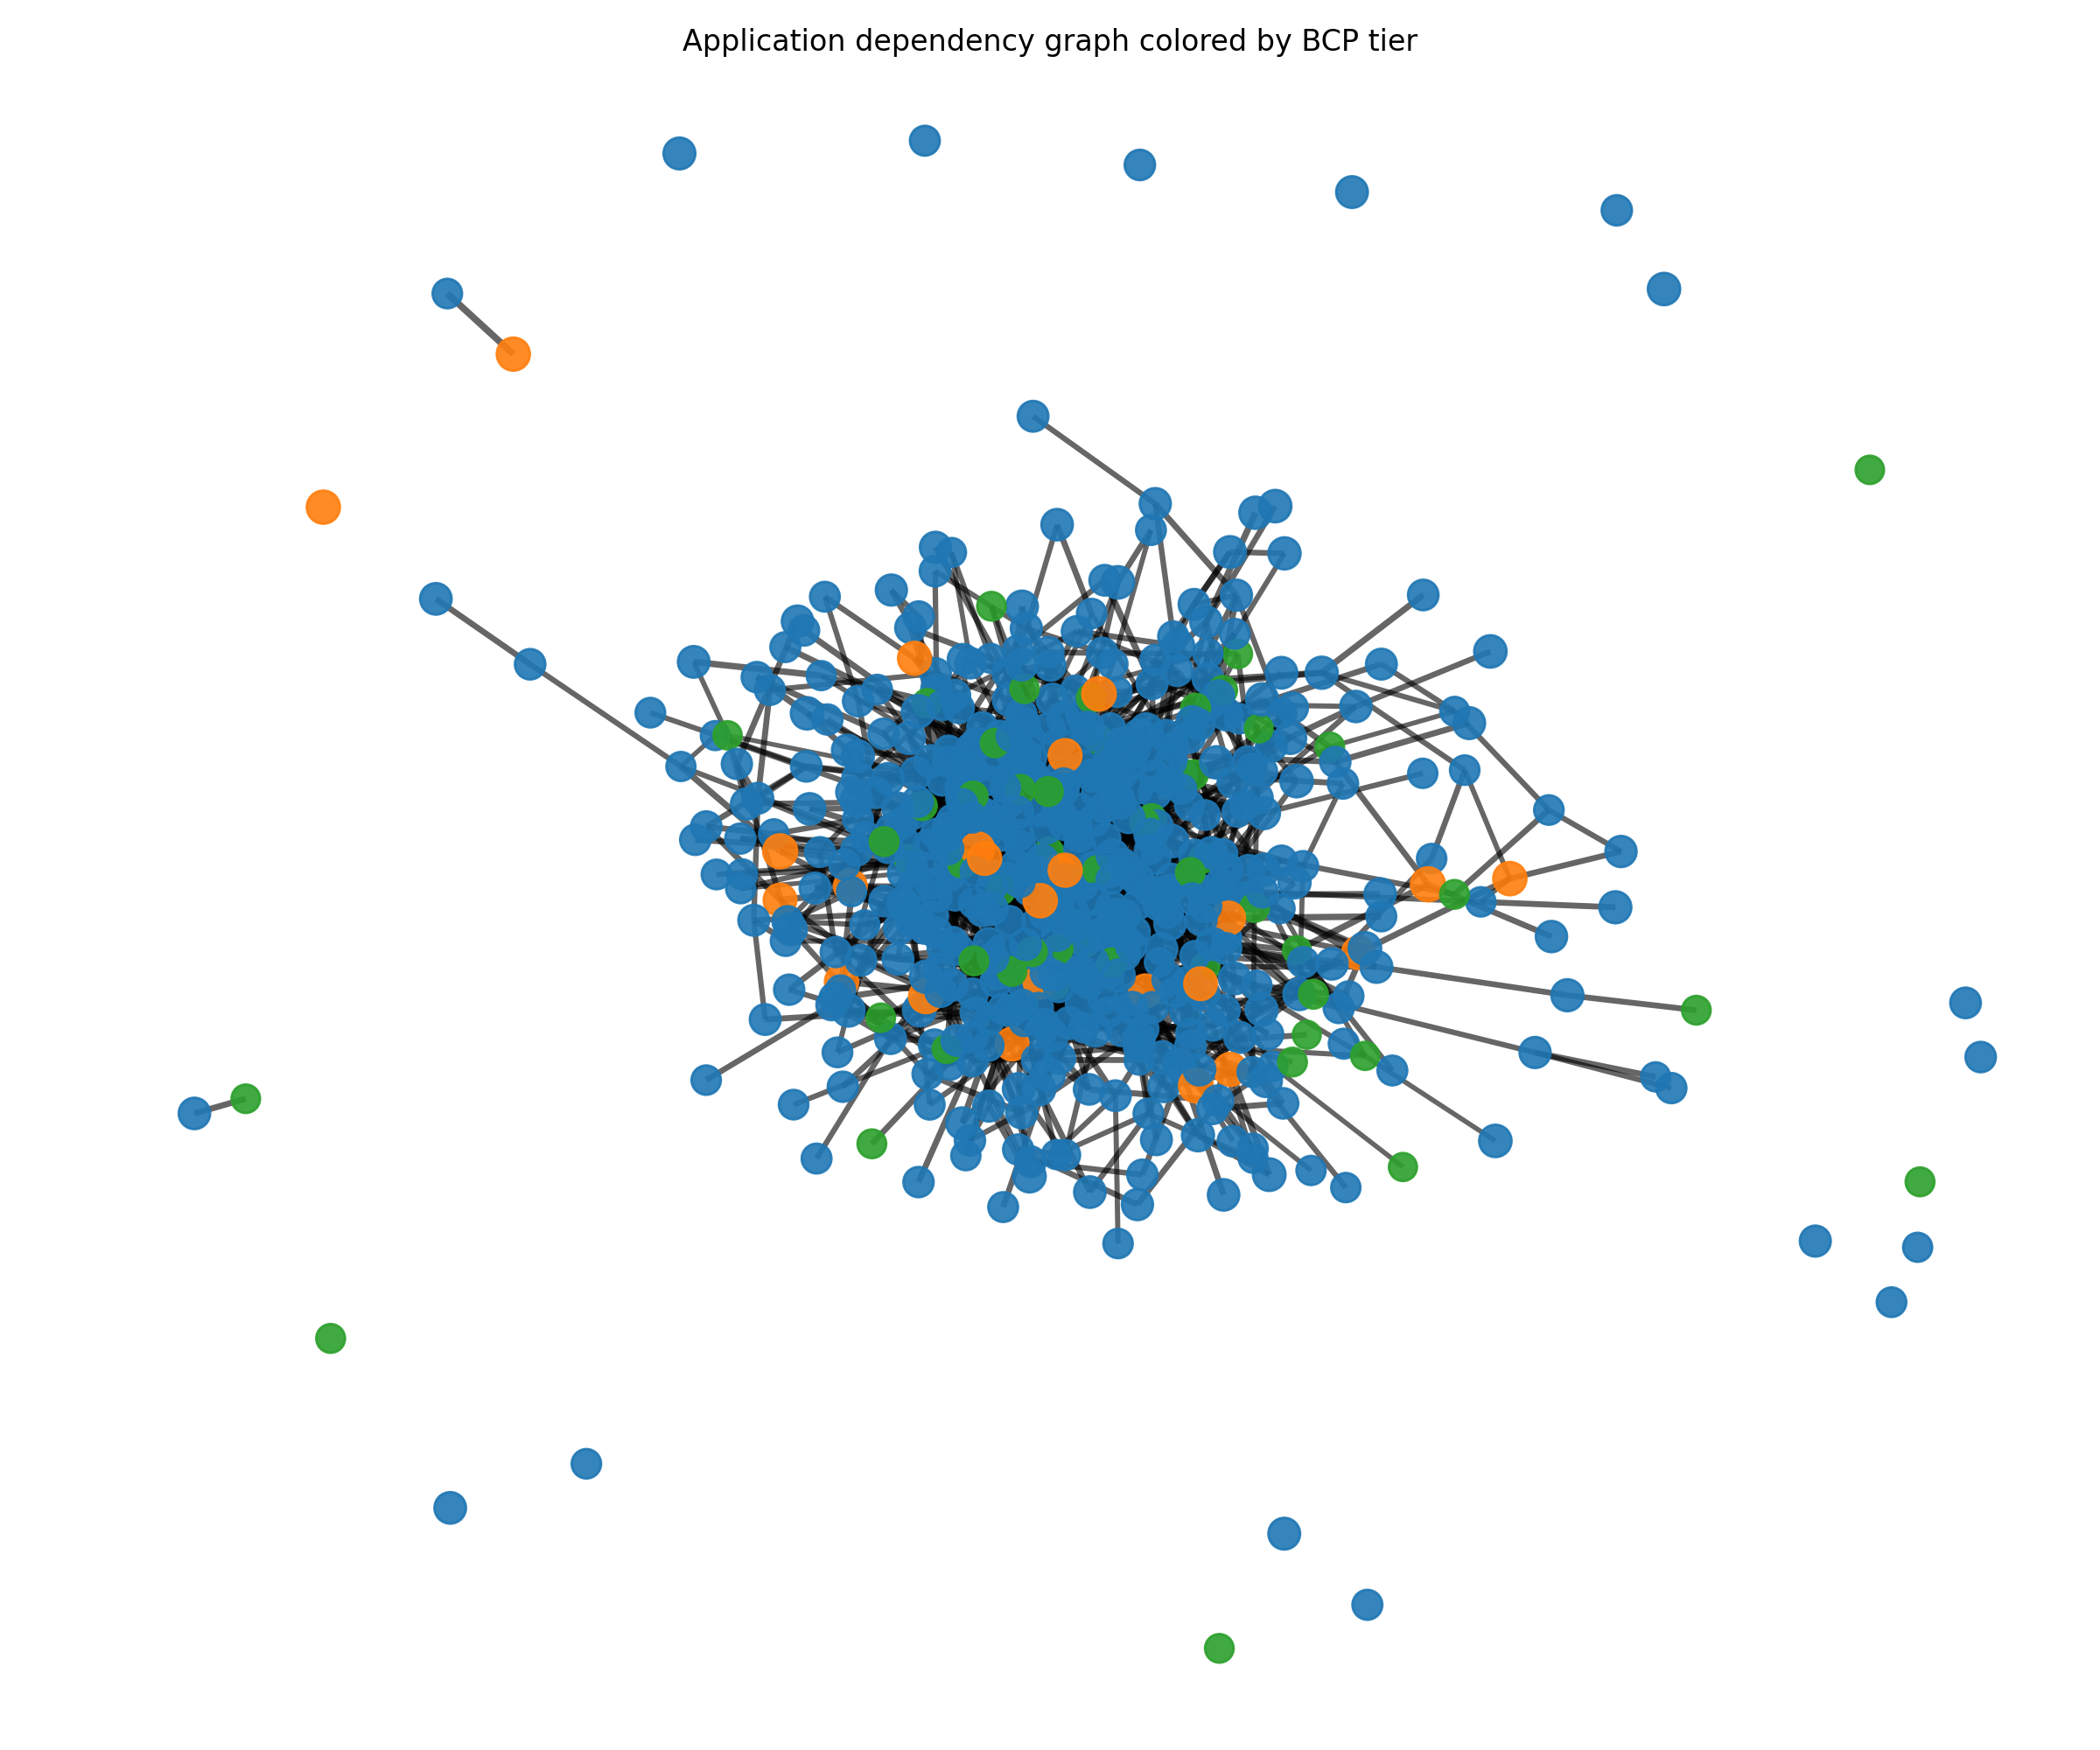

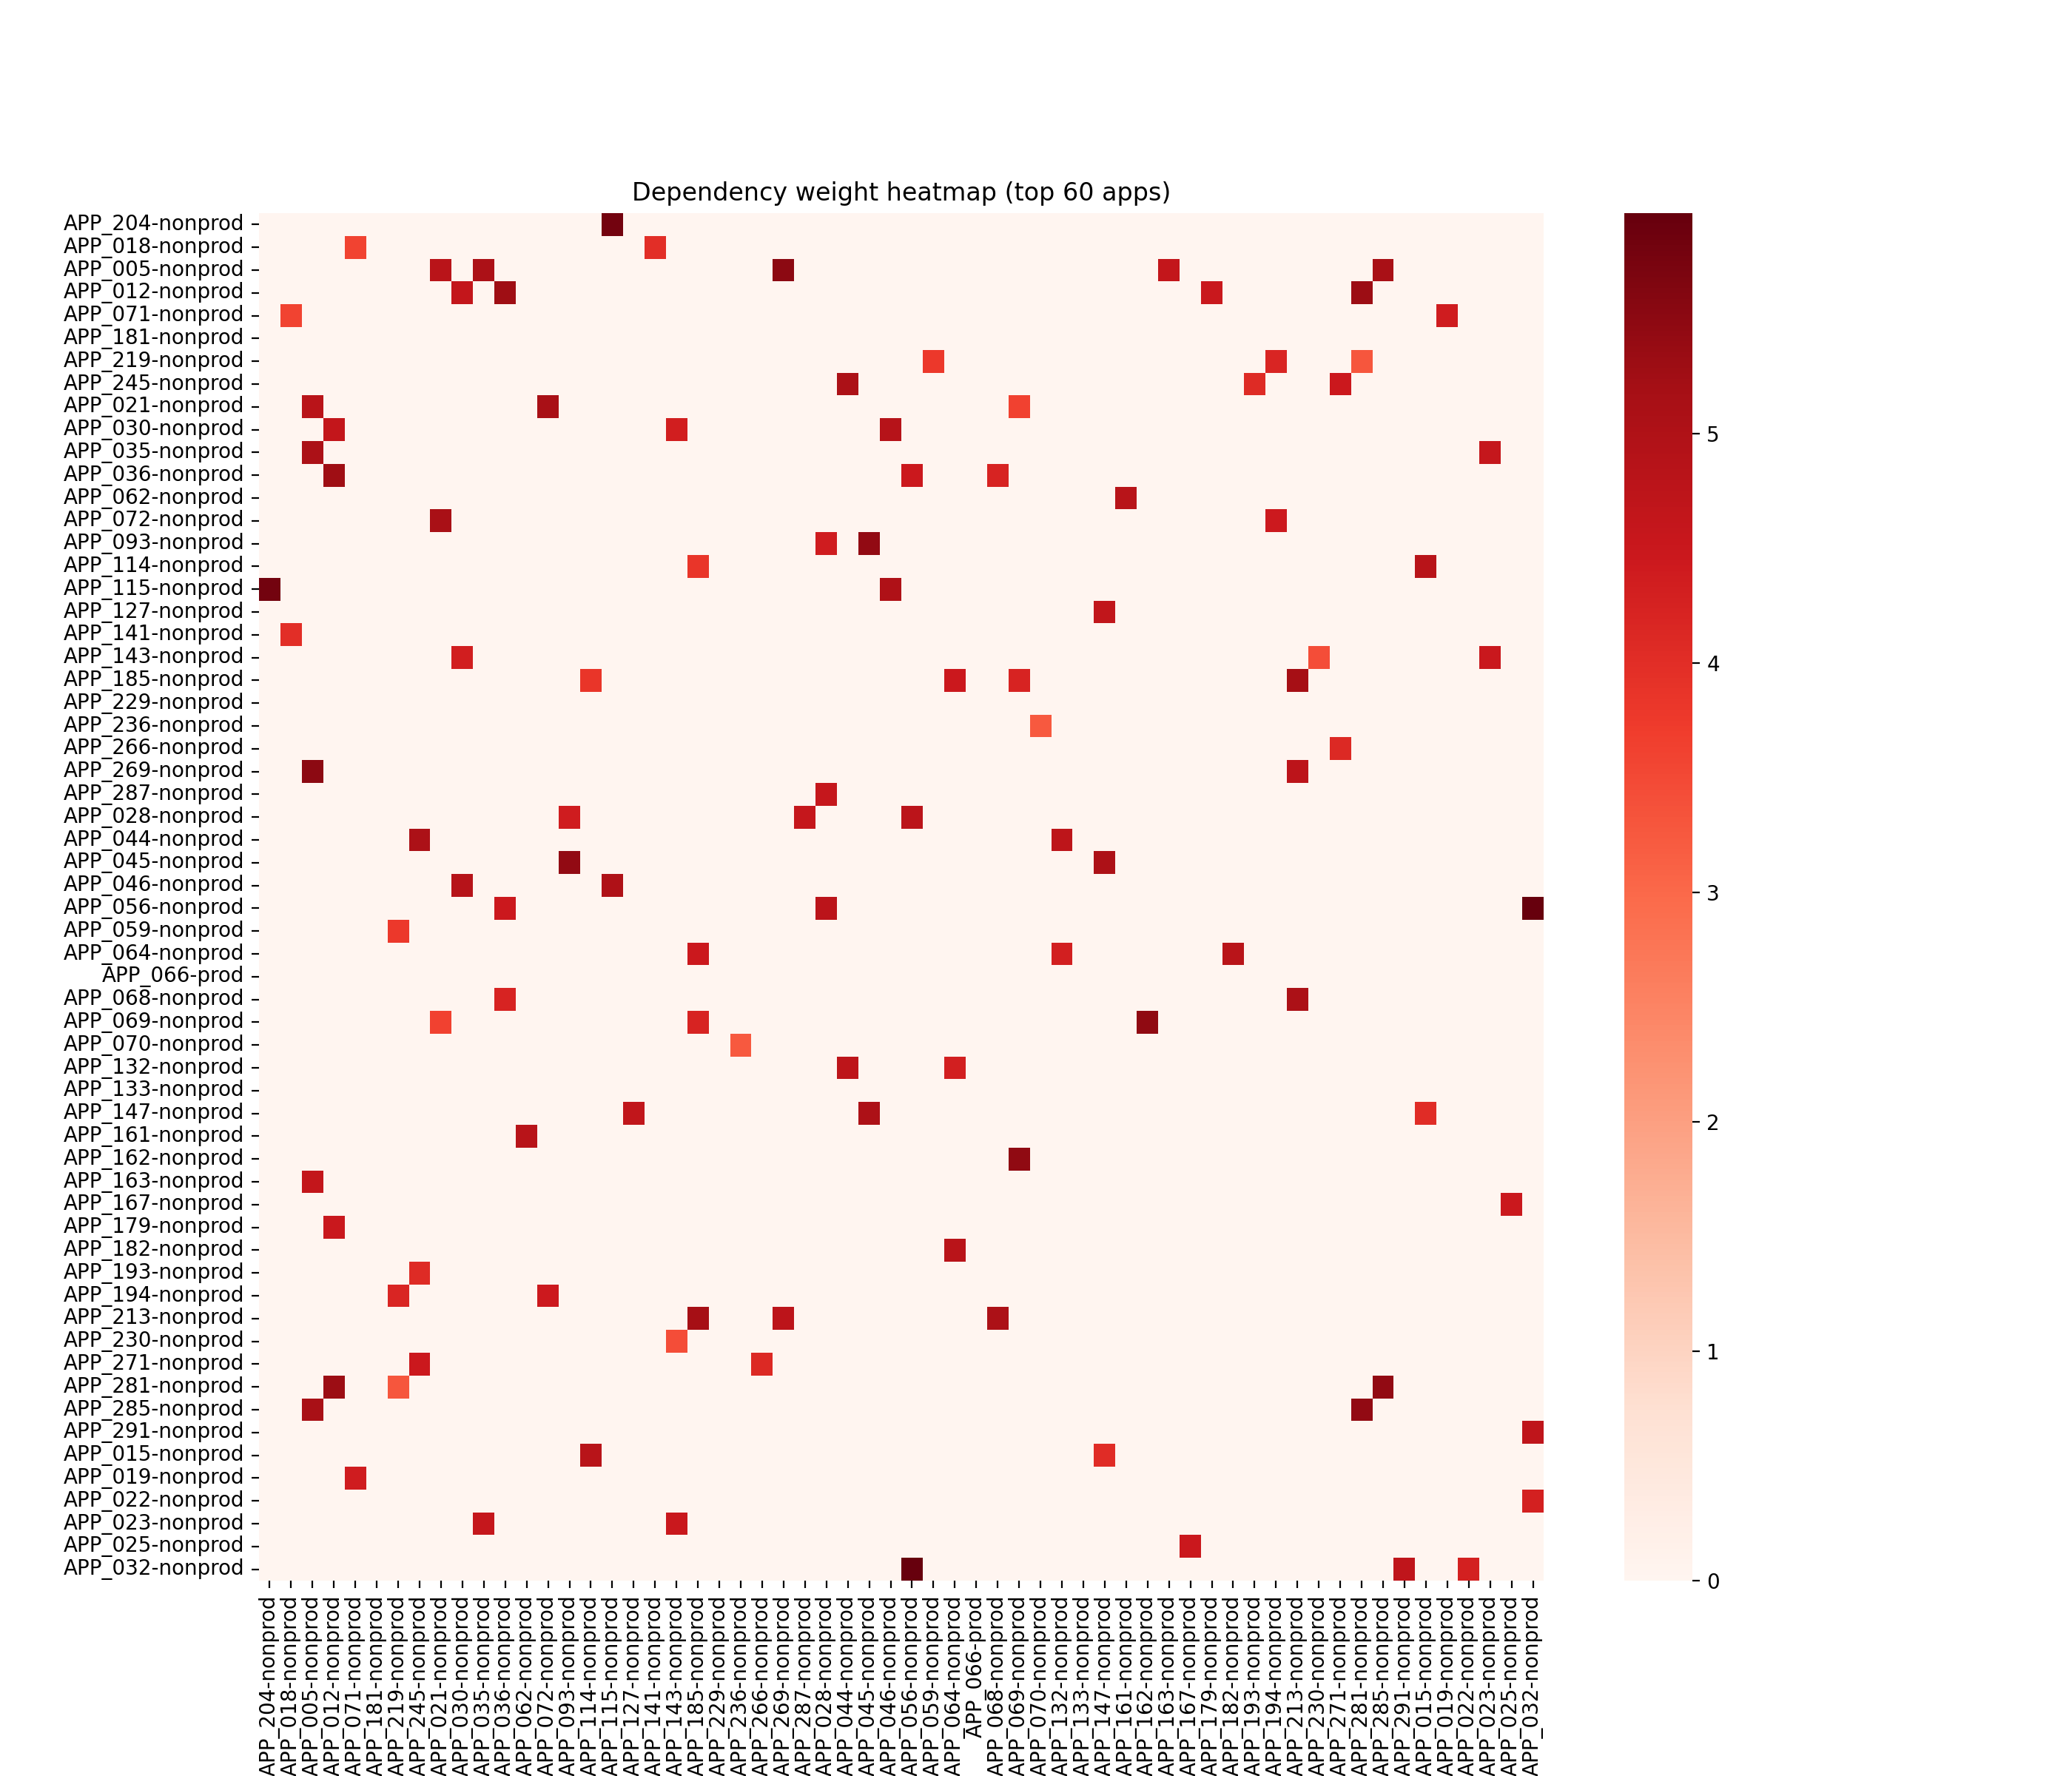

In [26]:
# Section 9: Visualizations (static + interactive)
import plotly.express as px

# Inline images from outputs
img1 = OUT_DIR / 'graph_bcp_colored.png'
img2 = OUT_DIR / 'dependency_heatmap_top60.png'
if img1.exists():
    display(Image(str(img1)))
if img2.exists():
    display(Image(str(img2)))

# BCP scatter if apps present
if 'apps' in globals():
    df = apps.copy()
    fig = px.scatter(df[df['env']=='prod'], x='BCP_score', y='financial_impact_k_per_hour', color='BCP_tier', hover_data=['app_instance_id','RTO_hours','RPO_minutes'])
    fig.update_layout(title='BCP score vs Financial impact (prod apps)')
    fig.show()

# per-wave business impact bar chart if available
bi_file = OUT_DIR / 'business_impact_waves_louvain.csv'
if bi_file.exists():
    bi = pd.read_csv(bi_file)
    fig = px.bar(bi, x='wave_index', y='total_fin_k_per_hour', color='env', barmode='group', title='Per-wave business impact (Louvain)')
    fig.show()


In [27]:
# Section 10: Parameter sweep and stability analysis (quick example)
from tqdm.notebook import tqdm

sweep_results = []
if community_louvain is not None:
    for res in [0.5,1.0,1.5]:
        for seed in [42,7,101]:
            start = time.perf_counter()
            part = community_louvain.best_partition(G, weight='weight')
            dur = time.perf_counter() - start
            ncom = len(set(part.values()))
            mod = community_louvain.modularity(part, G, weight='weight')
            sweep_results.append({'algorithm':'louvain','resolution':res,'seed':seed,'ncom':ncom,'modularity':mod,'time_s':dur})

if leidenalg is not None and ig is not None:
    for res in [0.5,1.0,1.5]:
        for seed in [42,7,101]:
            part = leidenalg.find_partition(g_ig, leidenalg.ModularityVertexPartition, weights='weight', seed=seed)
            membership = part.membership
            ncom = len(set(membership))
            mod = g_ig.modularity(membership, weights=weights)
            sweep_results.append({'algorithm':'leiden','resolution':res,'seed':seed,'ncom':ncom,'modularity':mod,'time_s':None})

sweep_df = pd.DataFrame(sweep_results)
if not sweep_df.empty:
    display(sweep_df)
    fig = px.line(sweep_df, x='resolution', y='modularity', color='algorithm', markers=True)
    fig.show()


algorithm  resolution  seed  ncom  modularity    time_s
0    louvain         0.5    42    38    0.510265  0.101589
1    louvain         0.5     7    39    0.509895  0.052671
2    louvain         0.5   101    39    0.510153  0.051223
3    louvain         1.0    42    39    0.502754  0.047055
4    louvain         1.0     7    39    0.507954  0.047922
5    louvain         1.0   101    39    0.505804  0.058246
6    louvain         1.5    42    40    0.509291  0.043151
7    louvain         1.5     7    39    0.505989  0.047814
8    louvain         1.5   101    39    0.505180  0.036558
9     leiden         0.5    42    37    0.518331       NaN
10    leiden         0.5     7    38    0.519807       NaN
11    leiden         0.5   101    36    0.523222       NaN
12    leiden         1.0    42    37    0.518331       NaN
13    leiden         1.0     7    38    0.519807       NaN
14    leiden         1.0   101    36    0.523222       NaN
15    leiden         1.5    42    37    0.518331       NaN
16    leiden         1.5     7    38    0.519807       NaN
17    leiden         1.5   101    36    0.523222       NaN

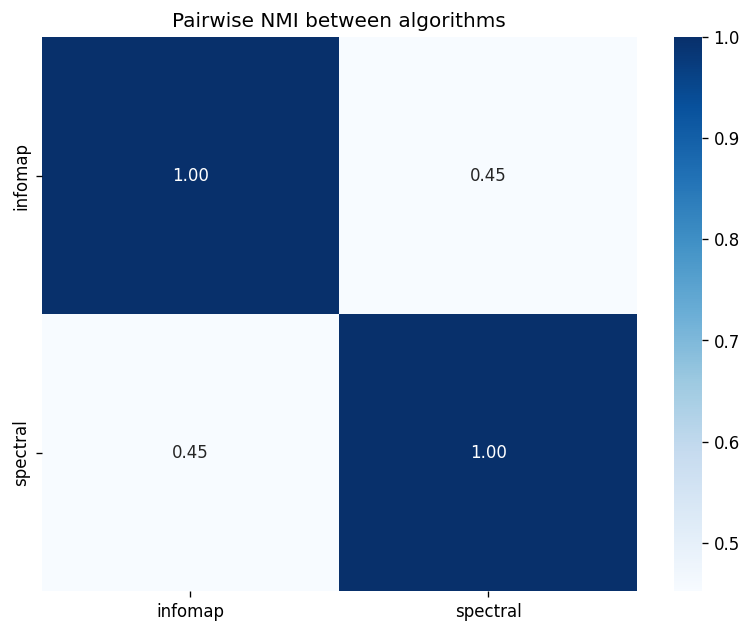

In [28]:
# Section 11: Compare algorithms (NMI heatmap and Sankey)
# NMI heatmap
names = list(label_arrays.keys())
ln = len(names)
nmi_mat = np.zeros((ln,ln))
for i in range(ln):
    for j in range(ln):
        if i==j: nmi_mat[i,j]=1.0
        else:
            nmi_mat[i,j] = normalized_mutual_info_score(label_arrays[names[i]], label_arrays[names[j]])

sns.heatmap(pd.DataFrame(nmi_mat, index=names, columns=names), annot=True, fmt='.2f', cmap='Blues')
plt.title('Pairwise NMI between algorithms')
plt.show()

# Sankey between two chosen partitions (louvain vs leiden if present)
try:
    import plotly.graph_objects as go
    if 'louvain' in label_arrays and 'leiden' in label_arrays:
        src_labels = label_arrays['louvain']
        tgt_labels = label_arrays['leiden']
        # map communities to indices for sankey
        src_names = sorted(set(src_labels))
        tgt_names = sorted(set(tgt_labels))
        src_idx = {c:i for i,c in enumerate(src_names)}
        tgt_idx = {c:i+len(src_names) for i,c in enumerate(tgt_names)}
        flows = {}
        for s,t in zip(src_labels, tgt_labels):
            key = (src_idx[s], tgt_idx[t])
            flows[key] = flows.get(key,0)+1
        node_labels = [f'Louv_{c}' for c in src_names] + [f'Leid_{c}' for c in tgt_names]
        link = dict(source=[k[0] for k in flows.keys()], target=[k[1] for k in flows.keys()], value=list(flows.values()))
        fig = go.Figure(go.Sankey(node=dict(label=node_labels), link=link))
        fig.update_layout(title='Louvain -> Leiden flow')
        fig.show()
except Exception as e:
    print('Sankey failed:', e)


In [29]:
# Section 12: Save and export results
OUT = Path('d:/Projects/Graph_Clustering/migration_planning/outputs')
OUT.mkdir(exist_ok=True)

# Save partition mappings
for name, mapping in all_parts.items():
    outp = OUT / f'partition_{name}.csv'
    pd.DataFrame([{'node':n,'community':c} for n,c in mapping.items()]).to_csv(outp, index=False)

# Save metrics
metrics_df = pd.DataFrame(results)
metrics_df.to_csv(OUT / 'clustering_metrics_summary.csv', index=False)

# Save sweep
if 'sweep_df' in globals() and not sweep_df.empty:
    sweep_df.to_csv(OUT / 'parameter_sweep_results.csv', index=False)

# Export interactive Plotly figures to HTML (if any open figures)
try:
    import plotly.io as pio
    # save last fig
    # user can save specific figs by modifying code
    pio.write_html(fig, OUT / 'last_plotly_fig.html')
except Exception:
    pass

print('Saved partitions and metrics to', OUT)


Saved partitions and metrics to d:\Projects\Graph_Clustering\migration_planning\outputs


In [30]:
# Section 13: Basic validation tests and assertions
# Basic assertions
assert G.number_of_nodes() > 0
if 'louvain' in label_arrays:
    assert len(label_arrays['louvain']) == G.number_of_nodes(), 'Louvain label count mismatch'
for name, arr in label_arrays.items():
    assert len(arr) == G.number_of_nodes(), f'{name} labels length mismatch'
print('Basic validation checks passed')

# Example pytest-compatible test function (optional)
def test_modularity_range():
    for r in results:
        if r['modularity'] is not None:
            assert -0.5 <= r['modularity'] <= 1.0


Basic validation checks passed


## Next steps & Checks

- Run the notebook cells sequentially to reproduce the analysis.
- Validate non-prod recovery procedures during early waves and record RTO/RPO test evidence.
- Share generated interactive HTML charts with stakeholders for review.
- Optionally run the parameter sweep with a wider range of resolution values and more seeds for robust stability analysis.

If you'd like, I can also:
- Export a printable migration schedule (per-wave runbook)
- Produce an interactive dashboard (Dash/Streamlit) to explore waves and dependencies


In [31]:
# Additional: Load validation issues and summary created by `plan_waves.py` (TARGET_WAVES_PER_ENV = 8)
val_summary = pd.read_csv(OUT_DIR / 'wave_validation_summary.csv')
display(val_summary)

# Show top issue counts for Louvain
issues_l = pd.read_csv(OUT_DIR / 'validation_issues_louvain.csv')
print('Top issue types (Louvain):')
print(issues_l['type'].value_counts().head(10))

# Show wave size distribution for nonprod/prod (Louvain)
stats_l = pd.read_csv(OUT_DIR / 'validation_stats_louvain.csv')
print('\nWave size stats (Louvain):')
print(stats_l.groupby('env')['num_apps'].describe())


algorithm  num_waves_nonprod  num_waves_prod  issues_found
0   louvain                  8               8           666
1    leiden                  8               8           666

Top issue types (Louvain):
type
cross_env_dependency                312
nonprod_not_before_prod             169
nonprod_production_gap_too_small    169
wave_size_out_of_bounds              16
Name: count, dtype: int64

Wave size stats (Louvain):
         count  mean       std   min   25%   50%   75%   max
env                                                         
nonprod    8.0  37.5  0.534522  37.0  37.0  37.5  38.0  38.0
prod       8.0  37.5  0.534522  37.0  37.0  37.5  38.0  38.0


### Interactive Dashboard (Streamlit)

The project includes a Streamlit dashboard to explore wave compositions and dependencies.

- Script: `dashboard.py` (created in project root)
- Run locally: `streamlit run d:/Projects/Graph_Clustering/migration_planning/dashboard.py`

The dashboard lets you select algorithm (Louvain/Leiden), environment (prod/nonprod), wave index, filter BCP range, and visualize the dependency graph for the selected wave. It also provides CSV export for selected waves.

Run the Streamlit command in a terminal (PowerShell/CMD). The dashboard will auto-load CSV and JSON outputs from `data/` and `outputs/`.


### Section: Wave & Overall Graph Visualizations 🗺️

This section adds inline visualizations to analyze the full application dependency graph and individual waves. It provides helper functions to render static Matplotlib plots and interactive Plotly graphs, plus a small interactive widget if `ipywidgets` is available.


Algorithm=louvain, env=nonprod, wave_index=0, num_apps=38


app_instance_id  app_type  BCP_score              BCP_tier  RTO_hours  \
209  APP_105-nonprod  frontend       7.12     Business Critical       9.63   
211  APP_106-nonprod  frontend       6.83     Business Critical       1.09   
577  APP_289-nonprod   backend       6.81     Business Critical       1.99   
387  APP_194-nonprod   backend       6.77     Business Critical      67.42   
561  APP_281-nonprod   backend       6.69     Business Critical      50.78   
83   APP_042-nonprod  frontend       6.69     Business Critical       0.68   
199  APP_100-nonprod  frontend       6.60     Business Critical       0.90   
551  APP_276-nonprod   backend       6.59     Business Critical       1.40   
3    APP_002-nonprod  frontend       6.53     Business Critical      17.43   
521  APP_261-nonprod   backend       6.52     Business Critical       1.22   
501  APP_251-nonprod   backend       6.50  Business Operational      33.64   
39   APP_020-nonprod  frontend       6.47  Business Operational      40.52   
201  APP_101-nonprod  frontend       6.45  Business Operational      15.29   
519  APP_260-nonprod   backend       6.44  Business Operational       8.07   
567  APP_284-nonprod   backend       6.36  Business Operational       3.53   
25   APP_013-nonprod  frontend       6.36  Business Operational       3.36   
503  APP_252-nonprod   backend       6.33  Business Operational       2.17   
5    APP_003-nonprod  frontend       6.32  Business Operational       8.49   
237  APP_119-nonprod  frontend       6.30  Business Operational       1.86   
425  APP_213-nonprod   backend       6.29  Business Operational       3.20   
113  APP_057-nonprod  frontend       6.26  Business Operational       9.39   
77   APP_039-nonprod  frontend       6.23  Business Operational      10.91   
491  APP_246-nonprod   backend       6.22  Business Operational      71.28   
553  APP_277-nonprod   backend       6.20  Business Operational       8.51   
331  APP_166-nonprod   backend       6.19  Business Operational      23.60   
475  APP_238-nonprod   backend       6.19  Business Operational       1.32   
479  APP_240-nonprod   backend       6.19  Business Operational      43.09   
453  APP_227-nonprod   backend       6.19  Business Operational      59.08   
363  APP_182-nonprod   backend       6.18  Business Operational      24.48   
351  APP_176-nonprod   backend       6.17  Business Operational      25.96   

     RPO_minutes  financial_impact_k_per_hour  
209          740                       604.87  
211           12                        55.51  
577           15                       116.78  
387          127                       543.38  
561           86                       220.65  
83            14                       250.58  
199           13                       634.19  
551           25                        81.07  
3            860                       172.87  
521           18                        26.94  
501          923                       331.51  
39           101                       993.41  
201          202                       246.68  
519          171                       102.28  
567          120                       407.37  
25          1340                       327.26  
503         1121                        85.29  
5            166                       245.46  
237           25                        20.09  
425         1176                        49.67  
113         1384                        34.86  
77           622                       577.37  
491          174                       209.07  
553         1328                       388.28  
331           62                       603.85  
475            5                        23.38  
479          520                       241.03  
453         1241                       788.68  
363          940                       428.30  
351          529                       122.45

Dependencies inside wave: 13


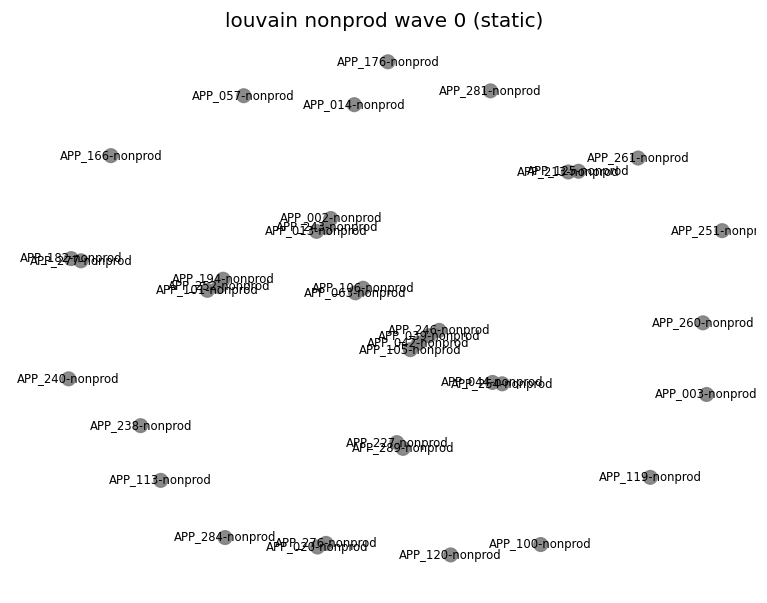

Algorithm=louvain, env=nonprod, wave_index=1, num_apps=38


app_instance_id  app_type  BCP_score              BCP_tier  RTO_hours  \
179  APP_090-nonprod  frontend       6.06  Business Operational      35.82   
65   APP_033-nonprod  frontend       6.06  Business Operational      25.25   
483  APP_242-nonprod   backend       6.05  Business Operational      50.54   
571  APP_286-nonprod   backend       6.05  Business Operational      63.84   
9    APP_005-nonprod  frontend       6.03  Business Operational       9.07   
313  APP_157-nonprod   backend       6.02  Business Operational      38.80   
473  APP_237-nonprod   backend       6.02  Business Operational      14.21   
585  APP_293-nonprod   backend       6.02  Business Operational      16.10   
75   APP_038-nonprod  frontend       6.02  Business Operational       1.41   
107  APP_054-nonprod  frontend       6.01  Business Operational      13.75   
235  APP_118-nonprod  frontend       6.01  Business Operational      14.30   
283  APP_142-nonprod   backend       6.01  Business Operational      48.51   
559  APP_280-nonprod   backend       5.99  Business Operational      30.46   
461  APP_231-nonprod   backend       5.98  Business Operational       1.98   
371  APP_186-nonprod   backend       5.96  Business Operational      55.01   
361  APP_181-nonprod   backend       5.95  Business Operational      55.95   
231  APP_116-nonprod  frontend       5.95  Business Operational      32.94   
467  APP_234-nonprod   backend       5.94  Business Operational      33.20   
439  APP_220-nonprod   backend       5.94  Business Operational      25.84   
487  APP_244-nonprod   backend       5.93  Business Operational       7.79   
185  APP_093-nonprod  frontend       5.93  Business Operational      32.86   
465  APP_233-nonprod   backend       5.93  Business Operational      29.97   
293  APP_147-nonprod   backend       5.91  Business Operational      64.26   
155  APP_078-nonprod  frontend       5.91  Business Operational       1.99   
365  APP_183-nonprod   backend       5.90  Business Operational      63.76   
89   APP_045-nonprod  frontend       5.90  Business Operational      52.35   
7    APP_004-nonprod  frontend       5.89  Business Operational      60.06   
143  APP_072-nonprod  frontend       5.88  Business Operational       0.32   
569  APP_285-nonprod   backend       5.88  Business Operational      13.76   
537  APP_269-nonprod   backend       5.85  Business Operational      56.00   

     RPO_minutes  financial_impact_k_per_hour  
179          364                        19.40  
65          1342                       161.79  
483          939                       999.08  
571           78                        29.97  
9            421                        34.89  
313         1114                       196.50  
473          255                        17.35  
585          213                        73.75  
75             9                         1.80  
107          886                        98.11  
235          566                        65.27  
283          150                       791.80  
559          785                       722.00  
461           14                         4.01  
371          277                       265.82  
361           37                        15.90  
231          415                       104.66  
467          581                       122.85  
439         1114                       659.83  
487           73                       110.72  
185          847                        85.00  
465         1091                       729.23  
293         1078                       378.92  
155           27                         7.01  
365          277                       477.02  
89           741                       210.03  
7            902                       279.79  
143           12                         1.95  
569          839                       193.53  
537           71                       169.21

Dependencies inside wave: 9


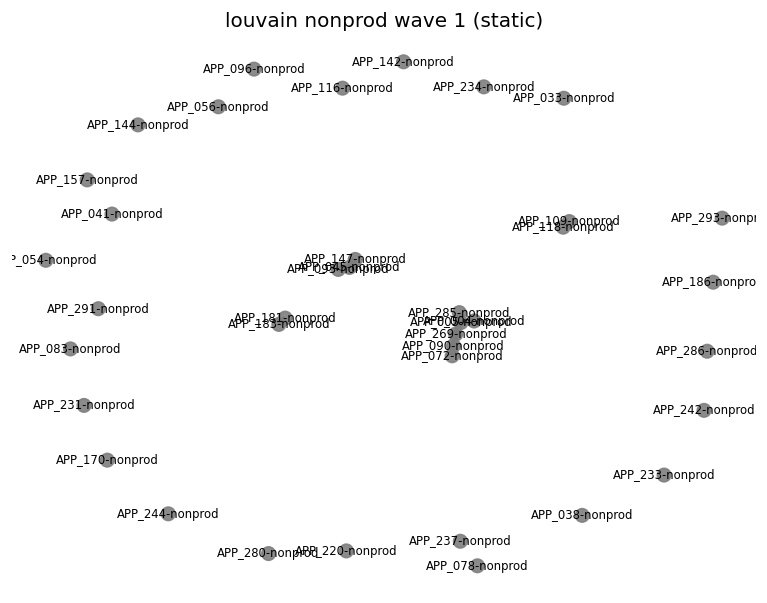

Algorithm=louvain, env=nonprod, wave_index=2, num_apps=38


app_instance_id  app_type  BCP_score              BCP_tier  RTO_hours  \
311  APP_156-nonprod   backend       5.77  Business Operational       3.84   
167  APP_084-nonprod  frontend       5.72  Business Operational      47.83   
547  APP_274-nonprod   backend       5.71  Business Operational       0.60   
309  APP_155-nonprod   backend       5.69  Business Operational      61.60   
93   APP_047-nonprod  frontend       5.69  Business Operational      18.19   
545  APP_273-nonprod   backend       5.68  Business Operational      58.30   
445  APP_223-nonprod   backend       5.68  Business Operational      15.12   
407  APP_204-nonprod   backend       5.67  Business Operational       1.52   
541  APP_271-nonprod   backend       5.67  Business Operational       1.76   
47   APP_024-nonprod  frontend       5.66  Business Operational      64.32   
255  APP_128-nonprod   backend       5.66  Business Operational      25.69   
301  APP_151-nonprod   backend       5.65  Business Operational       0.37   
533  APP_267-nonprod   backend       5.64  Business Operational       0.40   
265  APP_133-nonprod   backend       5.64  Business Operational      28.37   
85   APP_043-nonprod  frontend       5.63  Business Operational      47.92   
291  APP_146-nonprod   backend       5.63  Business Operational      40.01   
215  APP_108-nonprod  frontend       5.63  Business Operational      47.56   
61   APP_031-nonprod  frontend       5.62  Business Operational      23.58   
53   APP_027-nonprod  frontend       5.60  Business Operational      44.82   
271  APP_136-nonprod   backend       5.58  Business Operational      19.50   
163  APP_082-nonprod  frontend       5.58  Business Operational      56.29   
587  APP_294-nonprod   backend       5.57  Business Operational      61.25   
189  APP_095-nonprod  frontend       5.56  Business Operational      69.40   
565  APP_283-nonprod   backend       5.56  Business Operational       1.70   
589  APP_295-nonprod   backend       5.56  Business Operational      68.41   
187  APP_094-nonprod  frontend       5.56  Business Operational      39.16   
593  APP_297-nonprod   backend       5.55  Business Operational      69.56   
197  APP_099-nonprod  frontend       5.54  Business Operational      68.22   
177  APP_089-nonprod  frontend       5.51  Business Operational      13.06   
67   APP_034-nonprod  frontend       5.51  Business Operational      17.57   

     RPO_minutes  financial_impact_k_per_hour  
311          811                         2.99  
167          247                         7.55  
547           16                         1.64  
309         1033                       512.03  
93          1008                        66.94  
545         1413                       655.12  
445          662                        16.56  
407            5                         1.19  
541            7                         7.71  
47           377                        23.88  
255          873                       143.52  
301           23                         2.92  
533           13                         6.51  
265          258                       211.53  
85            37                       100.89  
291          387                       103.08  
215         1114                        76.45  
61          1297                       152.93  
53          1421                        41.30  
271          934                       313.67  
163           91                        95.24  
587         1243                       695.40  
189          228                       734.52  
565           29                         0.33  
589         1146                       696.06  
187         1318                       209.84  
593           75                        25.68  
197          620                        93.13  
177          652                         2.41  
67          1181                         6.94

Dependencies inside wave: 6


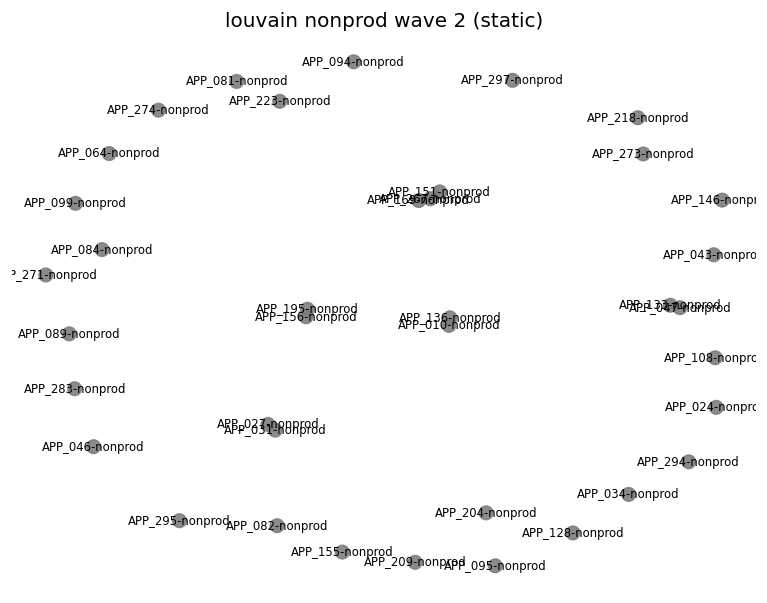

In [32]:
# Load waves and helper functions for visualization
import json
from pathlib import Path
import math
OUT = Path('d:/Projects/Graph_Clustering/migration_planning/outputs')

with open(OUT / 'waves_louvain.json') as f:
    waves_louv = json.load(f)
with open(OUT / 'waves_leiden.json') as f:
    waves_leid = json.load(f)

# Tier color map
tier_colors = {'Mission Critical':'#d62728','Business Critical':'#ff7f0e','Business Operational':'#1f77b4','Non-Critical':'#2ca02c'}

# helper: static and interactive plot for a given set of nodes
def plot_subgraph(nodes, title='Subgraph', edge_df=None, layout_seed=42, interactive=True):
    # nodes: list of app_instance_id
    sub = G.subgraph(nodes)
    pos = nx.spring_layout(sub, seed=layout_seed, k=0.15)
    # static Matplotlib
    import matplotlib.pyplot as plt
    colors = [tier_colors.get(G.nodes[n].get('BCP_tier',''), '#7f7f7f') for n in sub.nodes()]
    sizes = [50 + 15 * float(G.nodes[n].get('BCP_score',1)) for n in sub.nodes()]
    plt.figure(figsize=(8,6))
    nx.draw_networkx_nodes(sub, pos, node_color=colors, node_size=sizes, alpha=0.9)
    wts = [d.get('weight',1.0) for u,v,d in sub.edges(data=True)]
    maxw = max(wts) if wts else 1.0
    nx.draw_networkx_edges(sub, pos, width=[1+3*(w/maxw) for w in wts], alpha=0.6)
    nx.draw_networkx_labels(sub, pos, font_size=7)
    plt.title(title + ' (static)')
    plt.axis('off')
    plt.show()

    # interactive Plotly
    if interactive:
        try:
            import plotly.graph_objects as go
            edge_x = []
            edge_y = []
            for u,v,data in sub.edges(data=True):
                x0,y0 = pos[u]; x1,y1 = pos[v]
                edge_x += [x0, x1, None]
                edge_y += [y0, y1, None]
            node_x = []
            node_y = []
            node_text = []
            node_colors = []
            node_sizes = []
            for n in sub.nodes():
                x,y = pos[n]
                node_x.append(x); node_y.append(y)
                r = apps[apps['app_instance_id']==n].iloc[0]
                node_text.append(f"{n}<br>BCP={r['BCP_score']}<br>RTO={r['RTO_hours']}h")
                node_colors.append(tier_colors.get(r['BCP_tier'],'#7f7f7f'))
                node_sizes.append(12 + r['BCP_score']*4)
            edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=1,color='rgba(0,0,0,0.15)'), hoverinfo='none')
            node_trace = go.Scatter(x=node_x, y=node_y, mode='markers+text', text=[n for n in sub.nodes()], textposition='top center', hovertext=node_text, marker=dict(color=node_colors, size=node_sizes, line_width=1))
            fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(title=title + ' (interactive)', showlegend=False, margin=dict(t=30,l=20,b=20,r=20)))
            fig.show()
        except Exception as e:
            print('Plotly interactive plot failed:', e)

# convenience function to analyze a wave
def analyze_wave(algorithm='louvain', env='prod', wave_index=0, interactive=True, show_top_n=30):
    waves = waves_louv if algorithm=='louvain' else waves_leid
    if env not in waves:
        print('No such environment:', env); return
    if wave_index < 0 or wave_index >= len(waves[env]):
        print('Wave index out of range (0..{})'.format(len(waves[env])-1)); return
    wave = waves[env][wave_index]
    print(f"Algorithm={algorithm}, env={env}, wave_index={wave_index}, num_apps={len(wave)}")
    if len(wave) == 0:
        print('Empty wave')
        return
    df = apps[apps['app_instance_id'].isin(wave)].sort_values('BCP_score', ascending=False)
    display(df[['app_instance_id','app_type','BCP_score','BCP_tier','RTO_hours','RPO_minutes','financial_impact_k_per_hour']].head(show_top_n))
    # dependencies inside wave
    wave_deps = deps[(deps['source'].isin(wave)) & (deps['target'].isin(wave))]
    print('Dependencies inside wave:', len(wave_deps))
    # plotting
    plot_subgraph(wave, title=f"{algorithm} {env} wave {wave_index}", edge_df=wave_deps, interactive=interactive)

# Example: display first 3 waves for Louvain nonprod (small quick check)
for i in range(min(3, len(waves_louv['nonprod']))):
    analyze_wave('louvain', 'nonprod', i, interactive=True)


In [ ]:
# Interactive in-notebook controls using ipywidgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    algo_dd = widgets.Dropdown(options=['louvain','leiden'], value='louvain', description='Algorithm:')
    env_dd = widgets.Dropdown(options=['nonprod','prod'], value='nonprod', description='Env:')

    def get_wave_count(algo, env):
        waves = waves_louv if algo == 'louvain' else waves_leid
        return len(waves.get(env, []))

    wave_slider = widgets.IntSlider(value=0, min=0, max=max(0, get_wave_count('louvain','nonprod')-1), description='Wave:')
    auto_toggle = widgets.Checkbox(value=False, description='Auto-run on change')
    show_btn = widgets.Button(description='Show wave', button_style='primary')
    out = widgets.Output()

    def update_slider(*args):
        n = get_wave_count(algo_dd.value, env_dd.value)
        wave_slider.max = max(0, n-1)
        if wave_slider.value > wave_slider.max:
            wave_slider.value = 0

    def on_change_run(change=None):
        if auto_toggle.value:
            show(None)

    def show(_=None):
        with out:
            clear_output(wait=True)
            alg = algo_dd.value
            env = env_dd.value
            idx = int(wave_slider.value)
            analyze_wave(alg, env, idx, interactive=True)

    algo_dd.observe(update_slider, names='value')
    env_dd.observe(update_slider, names='value')
    algo_dd.observe(on_change_run, names='value')
    env_dd.observe(on_change_run, names='value')
    wave_slider.observe(on_change_run, names='value')

    show_btn.on_click(show)

    display(widgets.HBox([algo_dd, env_dd, wave_slider, auto_toggle, show_btn]))
    display(out)

except Exception as e:
    print('ipywidgets is not available. Install it with: pip install ipywidgets and enable the widget extension for your Jupyter environment. Error:', e)


Output()

In [36]:
# Per-wave metrics and bar chart: apps, servers, dbs, and aggregated risk score
import plotly.graph_objects as go
import pandas as pd


def compute_wave_metrics(algorithm='louvain', env='prod'):
    waves = waves_louv if algorithm == 'louvain' else waves_leid
    if env not in waves:
        raise ValueError(f'No such environment: {env}')
    rows = []
    for i, wave in enumerate(waves[env]):
        apps_in_wave = set(wave)
        num_apps = len(apps_in_wave)
        # servers and dbs referenced by these apps (unique)
        srv_targets = deps[(deps['source'].isin(apps_in_wave)) & (deps['target_type']=='server')]['target'].unique().tolist()
        db_targets = deps[(deps['source'].isin(apps_in_wave)) & (deps['target_type']=='database')]['target'].unique().tolist()
        num_servers = len(srv_targets)
        num_dbs = len(db_targets)
        bcp_vals = apps[apps['app_instance_id'].isin(apps_in_wave)]['BCP_score']
        risk_sum = float(bcp_vals.sum()) if not bcp_vals.empty else 0.0
        risk_avg = float(bcp_vals.mean()) if not bcp_vals.empty else 0.0
        rows.append({'wave_index': i, 'num_apps': num_apps, 'num_servers': num_servers, 'num_dbs': num_dbs, 'risk_sum': risk_sum, 'risk_avg': risk_avg})
    return pd.DataFrame(rows)


def plot_wave_metrics(algorithm='louvain', env='prod'):
    df = compute_wave_metrics(algorithm, env)
    if df.empty:
        print('No waves found for selection')
        return
    # Create bar traces for counts and line for risk sum
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df['wave_index'], y=df['num_apps'], name='Applications', marker_color='#1f77b4'))
    fig.add_trace(go.Bar(x=df['wave_index'], y=df['num_servers'], name='Servers', marker_color='#2ca02c'))
    fig.add_trace(go.Bar(x=df['wave_index'], y=df['num_dbs'], name='Databases', marker_color='#9467bd'))
    fig.add_trace(go.Scatter(x=df['wave_index'], y=df['risk_sum'], name='BCP Sum (risk)', yaxis='y2', mode='lines+markers', marker=dict(color='#d62728')))

    fig.update_layout(title=f'Wave metrics — {algorithm} / {env}', barmode='group', xaxis_title='Wave Index', yaxis=dict(title='Counts'), yaxis2=dict(title='Sum of BCP (risk)', overlaying='y', side='right'))
    fig.update_xaxes(type='category')
    fig.show()
    display(df)

# quick example: plot for Louvain prod
plot_wave_metrics('louvain','prod')

# interactive widget
try:
    import ipywidgets as widgets
    from IPython.display import display
    algo_w = widgets.Dropdown(options=['louvain','leiden'], value='louvain', description='Algorithm')
    env_w = widgets.Dropdown(options=['nonprod','prod'], value='prod', description='Env')
    out = widgets.Output()
    def on_change(_=None):
        with out:
            out.clear_output()
            plot_wave_metrics(algo_w.value, env_w.value)
    algo_w.observe(on_change, names='value')
    env_w.observe(on_change, names='value')
    display(widgets.HBox([algo_w, env_w]))
    display(out)
except Exception:
    print('ipywidgets not available; run plot_wave_metrics(algorithm, env) manually')

wave_index  num_apps  num_servers  num_dbs  risk_sum  risk_avg
0           0        38           83       36    248.12  6.529474
1           1        38           90       28    228.71  6.018684
2           2        38           94       32    217.06  5.712105
3           3        38           90       32    206.03  5.421842
4           4        37           88       21    192.30  5.197297
5           5        37           87       30    183.07  4.947838
6           6        37           71       29    174.11  4.705676
7           7        37           94       22    161.35  4.360811

Output()